#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [0]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
!pip install efficientnet

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}'}

In [0]:
!rm ~/.kaggle -rf
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}

In [0]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 441M/450M [00:17<00:00, 24.8MB/s]
100% 450M/450M [00:17<00:00, 26.6MB/s]


In [0]:
!unzip /content/flowers-recognition.zip 

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

# Constants and imports


In [0]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 
import time

import pandas as pd
import seaborn

Using TensorFlow backend.


In [0]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'
TULIP_DIR = 'tulip'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR, TULIP_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [0]:
(X,Y) = load_dataset()

  2%|▏         | 15/769 [00:00<00:05, 149.68it/s]

Loading data from: /content/flowers/daisy/


  3%|▎         | 29/1055 [00:00<00:03, 287.41it/s]

Loading data from: /content/flowers/dandelion/


  4%|▍         | 33/784 [00:00<00:02, 327.26it/s]

Loading data from: /content/flowers/rose/


  5%|▍         | 34/734 [00:00<00:02, 337.63it/s]

Loading data from: /content/flowers/sunflower/


  4%|▍         | 42/984 [00:00<00:02, 415.17it/s]

Loading data from: /content/flowers/tulip/


100%|██████████| 984/984 [00:02<00:00, 346.34it/s]


In [0]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 4323
Total number of labels: 4323


**Split train, valid and test datasets**

In [0]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 3242
Validation dataset size: 810
Test dataset size: 271


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  start = time.time()
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  plt.figure(figsize = (10,7))
  norm_cm = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred, normalize='true')
  norm_cm_df = pd.DataFrame(norm_cm, index=encoder.classes_, columns=encoder.classes_)
  seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(Y_test)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [0]:
test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).batch(1)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=True), num_parallel_calls=AUTOTUNE)
train_dataset = batch_and_prefetch(train_dataset)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


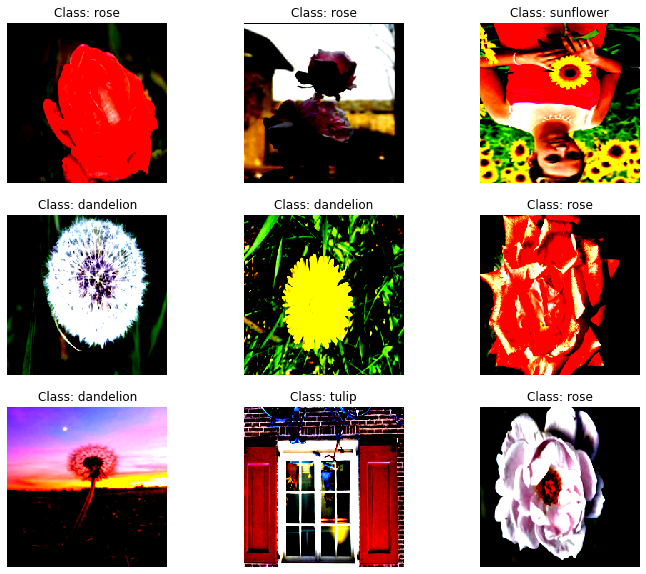

In [0]:
a, b = next(iter(train_dataset))
show_batch(a,b)

# Training from scratch

In [0]:
import efficientnet.tfkeras as efn

In [0]:
conv_base = efn.EfficientNetB1(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.summary()

Model: "efficientnet-b1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 7, 7, 1280)        6575232   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 313605    
Total params: 6,888,837
Trainable params: 6,826,789
Non-trainable params: 62,048
_________________________________________________________________


In [0]:
epochs = 40
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/40
101/101 [==============================] - 50s 495ms/step - loss: 1.8255 - accuracy: 0.2469 - val_loss: 2.0431 - val_accuracy: 0.3137
Epoch 2/40
101/101 [==============================] - 34s 336ms/step - loss: 1.7495 - accuracy: 0.2720 - val_loss: 1.8939 - val_accuracy: 0.3237
Epoch 3/40
101/101 [==============================] - 34s 336ms/step - loss: 1.7585 - accuracy: 0.2791 - val_loss: 1.8236 - val_accuracy: 0.2937
Epoch 4/40
101/101 [==============================] - 34s 338ms/step - loss: 1.7268 - accuracy: 0.2828 - val_loss: 1.7126 - val_accuracy: 0.3212
Epoch 5/40
101/101 [==============================] - 34s 336ms/step - loss: 1.6915 - accuracy: 0.2881 - val_loss: 1.6454 - val_accuracy: 0.3075
Epoch 6/40
101/101 [==============================] - 33s 325ms/step - loss: 1.6635 - accuracy

In [0]:
history_2 = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/40
101/101 [==============================] - 34s 334ms/step - loss: 1.1377 - accuracy: 0.5251 - val_loss: 1.1342 - val_accuracy: 0.5675
Epoch 2/40
101/101 [==============================] - 34s 337ms/step - loss: 1.1235 - accuracy: 0.5362 - val_loss: 1.0329 - val_accuracy: 0.6087
Epoch 3/40
101/101 [==============================] - 33s 324ms/step - loss: 1.1295 - accuracy: 0.5387 - val_loss: 1.1638 - val_accuracy: 0.5850
Epoch 4/40
101/101 [==============================] - 33s 326ms/step - loss: 1.1026 - accuracy: 0.5511 - val_loss: 1.2232 - val_accuracy: 0.6012
Epoch 5/40
101/101 [==============================] - 33s 324ms/step - loss: 1.1151 - accuracy: 0.5436 - val_loss: 1.1783 - val_accuracy: 0.5675
Epoch 6/40
101/101 [==============================] - 33s 324ms/step - loss: 1.1049 - accuracy

In [53]:
history_3 = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/40
101/101 [==============================] - 34s 342ms/step - loss: 0.8410 - accuracy: 0.6736 - val_loss: 0.7798 - val_accuracy: 0.6988
Epoch 2/40
101/101 [==============================] - 33s 324ms/step - loss: 0.8063 - accuracy: 0.6785 - val_loss: 0.9488 - val_accuracy: 0.6650
Epoch 3/40
101/101 [==============================] - 33s 323ms/step - loss: 0.8342 - accuracy: 0.6726 - val_loss: 0.7837 - val_accuracy: 0.7000
Epoch 4/40
101/101 [==============================] - 33s 324ms/step - loss: 0.8232 - accuracy: 0.6816 - val_loss: 0.8095 - val_accuracy: 0.7013
Epoch 5/40
101/101 [==============================] - 34s 339ms/step - loss: 0.8126 - accuracy: 0.6853 - val_loss: 0.7568 - val_accuracy: 0.7163
Epoch 6/40
101/101 [==============================] - 33s 326ms/step - loss: 0.8094 - accuracy

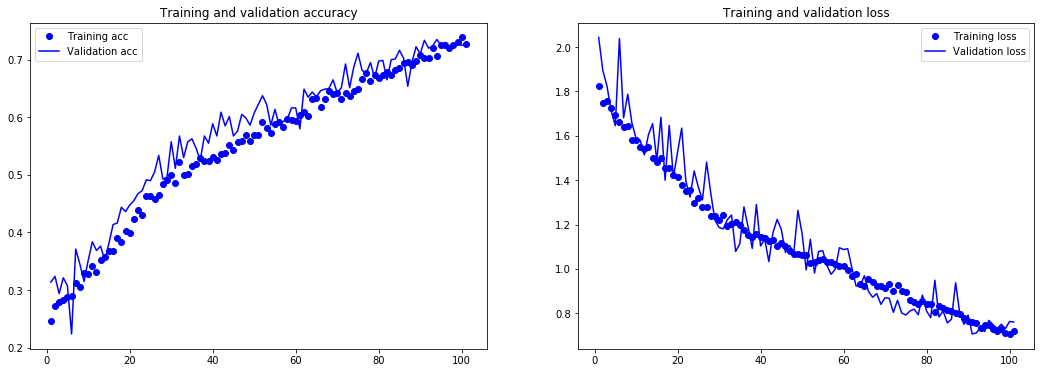

|Average prediction time: 15.90 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.72|0.72|0.72
|Macro|0.75|0.71|0.72


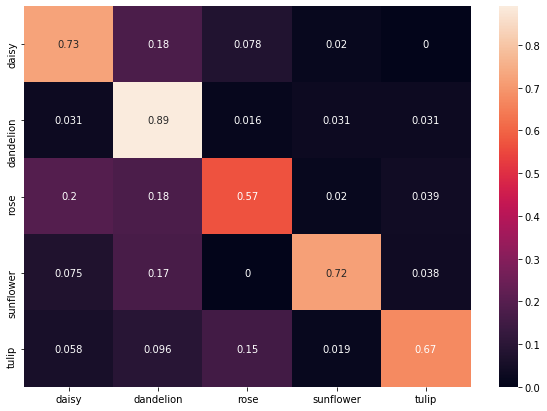

In [64]:
acc = history.history['accuracy'] + history_2.history['accuracy'] + history_3.history['accuracy']
val_acc = history.history['val_accuracy'] + history_2.history['val_accuracy'] + history_3.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()





loss = history.history['loss'] + history_2.history['loss'] + history_3.history['loss']
val_loss = history.history['val_loss'] + history_2.history['val_loss'] + history_3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




show_scores(model)

# Feature extraction with Dense hidden layer and GlobalMaxPooling

> Indented block




In [0]:
import efficientnet.tfkeras as efn

# Use layers=tf.keras.layers in order to fix Keras bug. See https://github.com/keras-team/keras/pull/9965
conv_base = efn.EfficientNetB1(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE,IMG_SIZE,3), layers=tf.keras.layers)

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

27164672/27164032 [==============================] - 0s 0us/step
Model: "efficientnet-b1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 1280)              6575232   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,581,637
Trainable params: 6,405
Non-trainable params: 6,575,232
_________________________________________________________________


In [0]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/30
101/101 [==============================] - 28s 276ms/step - loss: 1.4862 - accuracy: 0.3543 - val_loss: 1.2424 - val_accuracy: 0.6062
Epoch 2/30
101/101 [==============================] - 11s 109ms/step - loss: 1.1142 - accuracy: 0.6535 - val_loss: 0.9663 - val_accuracy: 0.7462
Epoch 3/30
101/101 [==============================] - 11s 109ms/step - loss: 0.9146 - accuracy: 0.7500 - val_loss: 0.8079 - val_accuracy: 0.7862
Epoch 4/30
101/101 [==============================] - 11s 110ms/step - loss: 0.7813 - accuracy: 0.7819 - val_loss: 0.7076 - val_accuracy: 0.8000
Epoch 5/30
101/101 [==============================] - 11s 109ms/step - loss: 0.6945 - accuracy: 0.8137 - val_loss: 0.6401 - val_accuracy: 0.8150
Epoch 6/30
101/101 [==============================] - 11s 109ms/step - loss: 0.6399 - accuracy

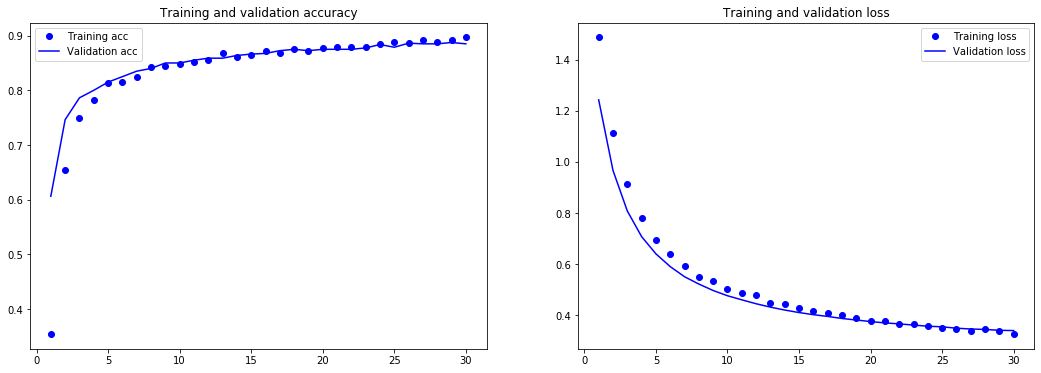

|Average prediction time: 21.98 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.92|0.92|0.92
|Macro|0.92|0.92|0.92


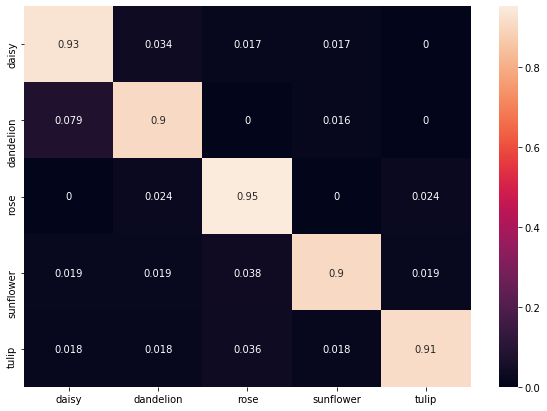

In [0]:
plot_curves(history)
show_scores(model)

# Fine tuning

In [0]:
for layer in conv_base.layers:
  if layer.name.startswith('block6') or layer.name.startswith('block7') or layer.name.startswith('top'):
    layer.trainable = True

In [0]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 1280)              6575232   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,581,637
Trainable params: 5,313,697
Non-trainable params: 1,267,940
_________________________________________________________________


In [0]:
epochs = 100
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/100
101/101 [==============================] - 26s 260ms/step - loss: 0.6317 - accuracy: 0.8032 - val_loss: 0.3639 - val_accuracy: 0.8800
Epoch 2/100
101/101 [==============================] - 14s 140ms/step - loss: 0.5405 - accuracy: 0.8379 - val_loss: 0.3828 - val_accuracy: 0.8712
Epoch 3/100
101/101 [==============================] - 14s 139ms/step - loss: 0.4541 - accuracy: 0.8645 - val_loss: 0.3757 - val_accuracy: 0.8737
Epoch 4/100
101/101 [==============================] - 15s 145ms/step - loss: 0.4260 - accuracy: 0.8673 - val_loss: 0.3613 - val_accuracy: 0.8788
Epoch 5/100
101/101 [==============================] - 15s 145ms/step - loss: 0.3812 - accuracy: 0.8846 - val_loss: 0.3432 - val_accuracy: 0.8900
Epoch 6/100
101/101 [==============================] - 15s 144ms/step - loss: 0.3699 - ac

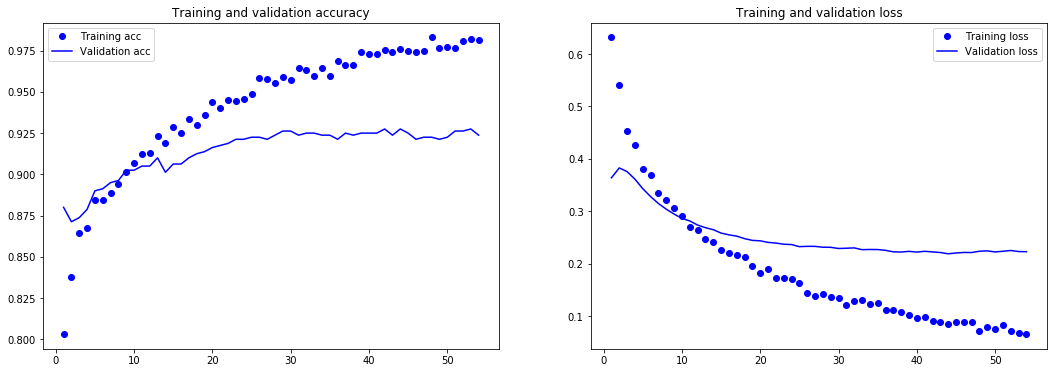

|Average prediction time: 17.22 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.95|0.95|0.95
|Macro|0.95|0.95|0.95


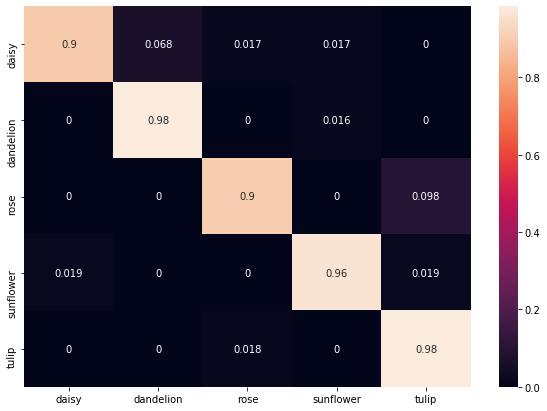

In [0]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 257 out of 271


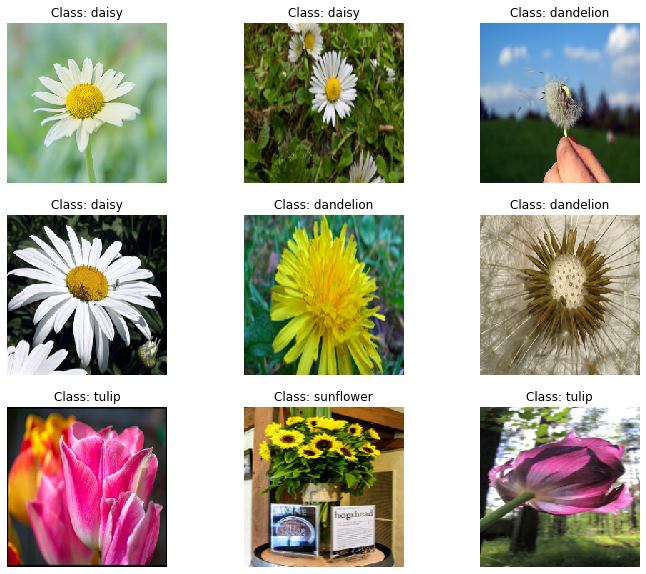

In [0]:
plot_correct_predictions(model)

Wrong predictions: 14 out of 271


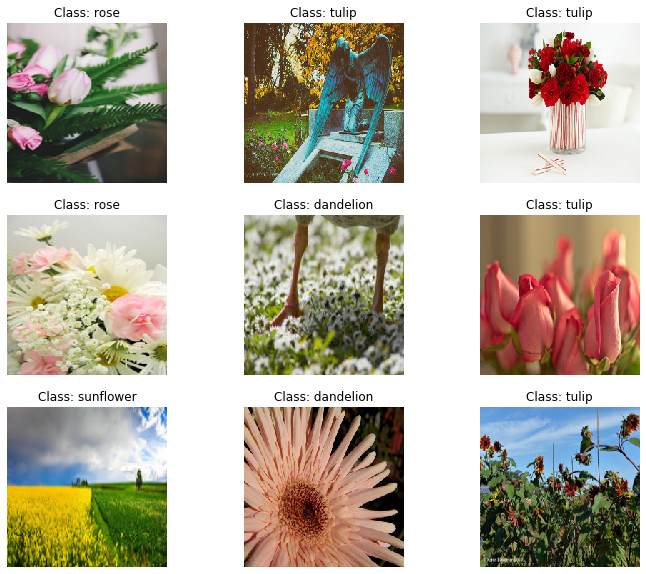

In [0]:

plot_wrong_predictions(model)